# Считаем метрики по ETS, ARIMA, RF.

In [2]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import os

from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [3]:
RANDOM_STATE = 42
HORIZON = 13

In [4]:
# --- Метрики ---
def smape(y_true, y_pred):
    return 100 * np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))

def evaluate(y_true, y_pred):
    return {
        "RMSE": np.sqrt(mean_squared_error(y_true, y_pred)),
        "MAE": mean_absolute_error(y_true, y_pred),
        "SMAPE": smape(y_true, y_pred)
    }

## ETS

#### seasonal == None

In [14]:
def forecast_ets(series, h=HORIZON):
    best_aic = np.inf
    best_res = None
    configs = [
        {'trend': 'add', 'damped_trend': True},
        {'trend': 'add', 'damped_trend': False},
        {'trend': None, 'damped_trend': False},
    ]
    for cfg in configs:
        try:
            model = ExponentialSmoothing(series,
                                         trend=cfg['trend'],
                                         damped_trend=cfg['damped_trend'],
                                         seasonal=None,
                                         initialization_method="estimated")
            res = model.fit(optimized=True)
            aic = res.aic
            if aic < best_aic:
                best_aic = aic
                best_res = res
        except:
            continue
    if best_res is None:
        return np.repeat(series.iloc[-1], h).astype(float)
    return best_res.forecast(h).values

#### seasonal ∈ [7, 14]

In [15]:
def forecast_ets_advanced(series, h=HORIZON):
    best_aic = np.inf
    best_res = None
    configs = []
    for trend in [None, "add", "mul"]:
        for damped in [True, False]:
            for seasonal in [None, "add", "mul"]:
                for sp in [None, 7, 14]:
                    if seasonal is None and sp is not None:
                        continue
                    configs.append((trend, damped, seasonal, sp))

    for trend, damped, seasonal, sp in configs:
        try:
            model = ExponentialSmoothing(series,
                                         trend=trend,
                                         damped_trend=damped,
                                         seasonal=seasonal,
                                         seasonal_periods=sp,
                                         initialization_method="estimated")
            res = model.fit(optimized=True)
            if res.aic < best_aic:
                best_aic = res.aic
                best_res = res
        except:
            continue

    if best_res is None:
        return np.repeat(series.iloc[-1], h).astype(float)
    return best_res.forecast(h).values


#### log

In [16]:
def forecast_ets_log(series, h=HORIZON):
    s = np.log1p(series)  # логарифмируем
    best_aic = np.inf
    best_res = None
    configs = [
        {'trend': 'add', 'damped_trend': True},
        {'trend': 'add', 'damped_trend': False},
        {'trend': None,  'damped_trend': False},
    ]
    for cfg in configs:
        try:
            model = ExponentialSmoothing(s,
                                         trend=cfg['trend'],
                                         damped_trend=cfg['damped_trend'],
                                         seasonal=None,
                                         initialization_method="estimated")
            res = model.fit(optimized=True)
            if res.aic < best_aic:
                best_aic = res.aic
                best_res = res
        except:
            continue
    if best_res is None:
        return np.repeat(series.iloc[-1], h).astype(float)

    forecast_log = best_res.forecast(h).values
    return np.expm1(forecast_log)  # обратное преобразование


## Prophet

In [17]:
from prophet import Prophet

def forecast_prophet(series, h=HORIZON):
    df = pd.DataFrame({
        "ds": pd.date_range(start="2023-07-02", periods=len(series), freq="D"),
        "y": series.values
    })
    model = Prophet(
        seasonality_mode="multiplicative", # т.к. тренд экспоненциальный
        yearly_seasonality=False,
        weekly_seasonality=True,
        daily_seasonality=False
    )
    model.fit(df)

    future = model.make_future_dataframe(periods=h, freq="D")
    forecast = model.predict(future)
    return forecast["yhat"].iloc[-h:].values


 ## Weighted Ensemble (Prophet + ETS_LOG)

In [24]:
def forecast_ensemble_weighted(hist, h=HORIZON, w_prophet=0.6, w_ets=0.4):
    prophet_pred = forecast_prophet(hist, h=h)

    ets_log_pred = forecast_ets_log(hist, h=h)

    # Взвешенное объединение
    ensemble = w_prophet * prophet_pred + w_ets * ets_log_pred
    return ensemble

## Grid search по весам Prophet + ETS_LOG

In [31]:
def tune_ensemble_weights(hist, horizon=HORIZON, step=0.01):
    train_part = hist[:-horizon]
    valid_part = hist[-horizon:]

    ets_log_pred = forecast_ets_log(train_part, h=horizon)
    prophet_pred = forecast_prophet(train_part, h=horizon)

    best_score = np.inf
    best_w = None
    best_metrics = None

    weights = np.arange(0, 1.01, step)  # от 0 до 1
    results = []

    for w in weights:
        ensemble_pred = w * prophet_pred + (1 - w) * ets_log_pred
        mets = evaluate(valid_part.values, ensemble_pred)
        results.append((w, mets))
        if mets["RMSE"] < best_score:
            best_score = mets["RMSE"]
            best_w = w
            best_metrics = mets

    # сохраняем результаты
    df_weights = pd.DataFrame([
        {"w_prophet": w, "RMSE": mets["RMSE"], "MAE": mets["MAE"], "SMAPE": mets["SMAPE"]}
        for w, mets in results
    ])
    df_weights.to_csv("ensemble_weight_tuning.csv", index=False)

    print(f"Лучший вес для Prophet: {best_w:.2f}")
    print("Метрики:", best_metrics)

    return best_w, best_metrics, df_weights

train = pd.read_csv("train.csv", parse_dates=['dt'])
test  = pd.read_csv("test.csv", parse_dates=['dt'])
hist  = pd.concat([train, test], ignore_index=True).sort_values('dt').reset_index(drop=True)
close = hist['close'].astype(float)

best_w, best_metrics, df_weights = tune_ensemble_weights(close, horizon=HORIZON)

DEBUG:cmdstanpy:input tempfile: /tmp/tmpjfzrv4bm/9sgy6kvn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpjfzrv4bm/z7tbjcwy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=733', 'data', 'file=/tmp/tmpjfzrv4bm/9sgy6kvn.json', 'init=/tmp/tmpjfzrv4bm/z7tbjcwy.json', 'output', 'file=/tmp/tmpjfzrv4bm/prophet_modelvdghwogu/prophet_model-20250818103211.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
10:32:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:32:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Лучший вес для Prophet: 0.60
Метрики: {'RMSE': np.float64(0.09665292034686392), 'MAE': 0.07843859481461218, 'SMAPE': np.float64(2.066441990995008)}


## ARIMA

In [7]:
def forecast_arima(series, h=HORIZON):
    best_aic = np.inf
    best_model = None
    s = series.astype(float)
    if len(s) < 10:
        return np.repeat(s.iloc[-1], h).astype(float)
    for p in range(0, 3):
        for d in range(0, 2):
            for q in range(0, 3):
                try:
                    model = ARIMA(s, order=(p,d,q))
                    res = model.fit()
                    if res.aic < best_aic:
                        best_aic = res.aic
                        best_model = res
                except:
                    continue
    if best_model is None:
        return np.repeat(s.iloc[-1], h).astype(float)
    return best_model.forecast(steps=h).values

## RandomForest recursive

In [8]:
def make_lag_features(df_close, max_lag=7):
    df = pd.DataFrame({'close': df_close})
    for lag in range(1, max_lag+1):
        df[f'lag_{lag}'] = df['close'].shift(lag)
    df['roll_mean_3'] = df['close'].shift(1).rolling(3, min_periods=1).mean()
    df['roll_std_3']  = df['close'].shift(1).rolling(3, min_periods=1).std(ddof=0).fillna(0)
    df['roll_mean_7'] = df['close'].shift(1).rolling(7, min_periods=1).mean()
    return df.dropna().reset_index(drop=True)

def forecast_rf_recursive(series, h=HORIZON, max_lag=7):
    s = pd.Series(series).reset_index(drop=True)
    df_all = make_lag_features(s, max_lag=max_lag)
    if df_all.shape[0] < 5:
        return np.repeat(s.iloc[-1], h).astype(float)
    X = df_all.drop(columns=['close']).values
    y = df_all['close'].values
    model = Ridge(alpha=1.0) if len(y) < 30 else RandomForestRegressor(
        n_estimators=400, max_depth=6, random_state=RANDOM_STATE, n_jobs=-1
    )
    model.fit(X, y)

    history = s.tolist()
    preds = []
    for _ in range(h):
        row = {}
        for lag in range(1, max_lag+1):
            row[f'lag_{lag}'] = history[-lag] if len(history) >= lag else history[0]
        temp = pd.Series(history)
        row['roll_mean_3'] = temp.shift(1).rolling(3, min_periods=1).mean().iloc[-1]
        row['roll_std_3']  = temp.shift(1).rolling(3, min_periods=1).std(ddof=0).iloc[-1]
        row['roll_mean_7'] = temp.shift(1).rolling(7, min_periods=1).mean().iloc[-1]
        feat_order = [f'lag_{i}' for i in range(1, max_lag+1)] + ['roll_mean_3','roll_std_3','roll_mean_7']
        x_row = np.array([row[k] for k in feat_order]).reshape(1, -1)
        yhat = model.predict(x_row)[0]
        preds.append(float(yhat))
        history.append(float(yhat))
    return np.array(preds)

## Procedures

In [26]:
# --- Validation procedure ---

def run_validation(hist, horizon=HORIZON):
    train_part = hist[:-horizon]
    valid_part = hist[-horizon:]

    print(f"Train length: {len(train_part)}, Validation length: {len(valid_part)}")

    ets_pred    = forecast_ets(train_part, h=horizon)
    ets_adv_pred= forecast_ets_advanced(train_part, h=horizon)
    ets_log_pred  = forecast_ets_log(train_part, h=horizon)
    prophet_pred  = forecast_prophet(train_part, h=horizon)
    #arima_pred  = forecast_arima(train_part, h=horizon)
    #rf_pred     = forecast_rf_recursive(train_part, h=horizon)

    # Prophet + ETS_LOG
    ensemble_weighted = forecast_ensemble_weighted(train_part, h=horizon, w_prophet=0.6, w_ets=0.4)

    # all
    ensemble_all = np.nanmean(np.vstack([ets_pred, ets_adv_pred, ets_log_pred, prophet_pred]), axis=0)

    results = {
        'ETS': evaluate(valid_part.values, ets_pred),
        'ETS_ADV': evaluate(valid_part.values, ets_adv_pred),
        'ETS_LOG': evaluate(valid_part.values, ets_log_pred),
        'PROPHET': evaluate(valid_part.values, prophet_pred),
        'ENSEMBLE_WEIGHTED': evaluate(valid_part.values, ensemble_weighted),
        'ENSEMBLE_ALL': evaluate(valid_part.values, ensemble_all)
    }

    # сохраняем предсказания
    df_preds = pd.DataFrame({
        'ID': np.arange(1, horizon+1),
        'actual': valid_part.values,
        'ets': ets_pred,
        'ets_adv': ets_adv_pred,
        'ets_log': ets_log_pred,
        'prophet': prophet_pred,
        'ensemble_weighted': ensemble_weighted,
        'ensemble_all': ensemble_all
    })
    df_preds.to_csv("validation_preds.csv", index=False)

    return results, df_preds

In [27]:
def main(train_path="train.csv", test_path="test.csv"):
    train = pd.read_csv(train_path, parse_dates=['dt'])
    test  = pd.read_csv(test_path, parse_dates=['dt'])
    hist  = pd.concat([train, test], ignore_index=True).sort_values('dt').reset_index(drop=True)
    close = hist['close'].astype(float)

    results, preds = run_validation(close, horizon=HORIZON)

    print("\nValidation metrics:")
    for model, mets in results.items():
        print(model, ":", ", ".join([f"{k}={v:.4f}" for k,v in mets.items()]))

    print("\nSaved predictions to validation_preds.csv")

if __name__ == "__main__":
    main()

Train length: 79, Validation length: 13


DEBUG:cmdstanpy:input tempfile: /tmp/tmpjfzrv4bm/6r11b6ng.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpjfzrv4bm/2dvaw22j.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=52495', 'data', 'file=/tmp/tmpjfzrv4bm/6r11b6ng.json', 'init=/tmp/tmpjfzrv4bm/2dvaw22j.json', 'output', 'file=/tmp/tmpjfzrv4bm/prophet_modelqh7kvs30/prophet_model-20250818100541.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
10:05:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:05:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpjfzrv4bm/7uepm9m9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpjfzrv4bm/ipw7xi2k.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local


Validation metrics:
ETS : RMSE=0.2738, MAE=0.2443, SMAPE=6.6586
ETS_ADV : RMSE=0.2738, MAE=0.2443, SMAPE=6.6586
ETS_LOG : RMSE=0.1555, MAE=0.1283, SMAPE=3.4582
PROPHET : RMSE=0.1253, MAE=0.1133, SMAPE=3.0300
ENSEMBLE_WEIGHTED : RMSE=0.0967, MAE=0.0784, SMAPE=2.0664
ENSEMBLE_ALL : RMSE=0.1741, MAE=0.1383, SMAPE=3.6849

Saved predictions to validation_preds.csv


# Validation metrics:

<font color='red'>ETS</font> : RMSE=0.2738, MAE=0.2443, SMAPE=6.6586

<font color='red'>ETS_SEASONAL</font> : RMSE=0.2738, MAE=0.2443, SMAPE=6.6586

<font color='red'>ARIMA</font> : RMSE=0.5109, MAE=0.4600, SMAPE=12.9800

<font color='red'>RF</font> : RMSE=0.7164, MAE=0.6684, SMAPE=19.5315

<font color='yellow'>ETS_LOG</font> : RMSE=0.1555, MAE=0.1283, SMAPE=3.4582

<font color='yellow'>PROPHET</font> : RMSE=0.1253, MAE=0.1133, SMAPE=3.0300

<font color='lightgreen'>ETS_LOG + PROPHET ENSEMBLE (0.4 / 0.6)</font> : RMSE=0.0967, MAE=0.0784, SMAPE=2.0664

<font color='orange'>ENSEMBLE (w/o ARIMA & RF)</font> : RMSE=0.1741, MAE=0.1383, SMAPE=3.6849

<font color='red'>ENSEMBLE_ALL</font> : RMSE=0.3154, MAE=0.2803, SMAPE=7.6749

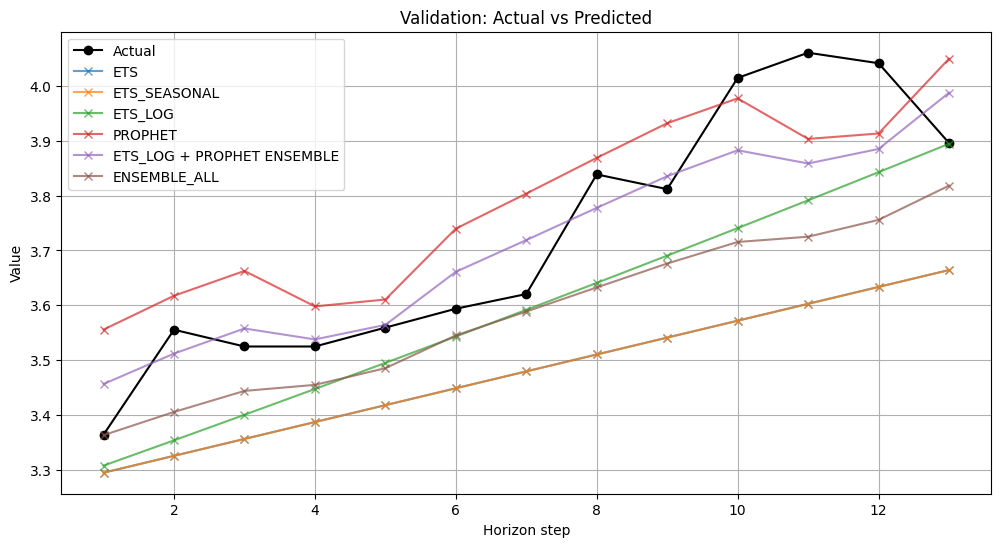

In [34]:
import pandas as pd
import matplotlib.pyplot as plt

df_preds = pd.read_csv("validation_preds.csv")

plt.figure(figsize=(12, 6))
plt.plot(df_preds['ID'], df_preds['actual'], marker='o', label='Actual', color='black')

# Отдельные модели
plt.plot(df_preds['ID'], df_preds['ets'], marker='x', label='ETS', alpha=0.7)
plt.plot(df_preds['ID'], df_preds['ets_adv'], marker='x', label='ETS_SEASONAL', alpha=0.7)
plt.plot(df_preds['ID'], df_preds['ets_log'], marker='x', label='ETS_LOG', alpha=0.7)
plt.plot(df_preds['ID'], df_preds['prophet'], marker='x', label='PROPHET', alpha=0.7)
plt.plot(df_preds['ID'], df_preds['ensemble_weighted'], marker='x', label='ETS_LOG + PROPHET ENSEMBLE', alpha=0.7)
plt.plot(df_preds['ID'], df_preds['ensemble_all'], marker='x', label='ENSEMBLE_ALL', alpha=0.7)

plt.xlabel("Horizon step")
plt.ylabel("Value")
plt.title("Validation: Actual vs Predicted")
plt.legend()
plt.grid(True)
plt.show()
